# Stepwise Regression

Stepwise regression is the step-by-step iterative construction of a regression model that involves the selection of independent variables to be used in a final model. It involves adding or removing potential explanatory variables in succession and testing for statistical significance after each iteration. In other words, in stepwise regression you have three choices:
* Forward selection: you start with a model with no explanatory variables and iteratively add variables in an hierarchical manner (starting with first degree terms, then second degree terms, etc.). At each iteration (addition of a variable), you will conduct a statistical test that will give you insight whether the added variable is significant or not, which will determine if the variable stays in the model or not. You will continue to do this until the model no longer improves significantly.
* Backward elimination: you start with a model consisting of all explanatory variables and iteratively remove variables. At each iteration, you will conduct a statistical test that will give you insight as to which variables is the least significant. That variable is removed at each iteration. You will continue to do this until all the remaining variables are significant enough (the level of significance is user-defined).
* Bidirectional elimination: a combination of the two methods previously mentioned, where at each step a variable is tested to judge whether it should be included in the model or not. 

Below, you can find a design for bidirectional elimination that should give you some intuition as to how stepwise regression works in general, and specifically how forward selection backward elimination works.
In this tutorial we will focus on backward elimination, where we will implement it from scratch (find the implementation below). For those interested, you are encouraged to try and implement forward selection and bidirectional elimination and benchmark it against backward elimination. 

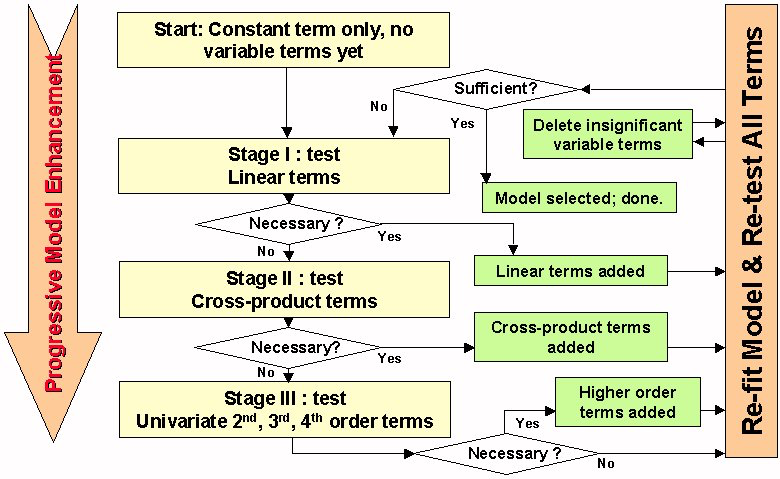

### Example

First, we will import all necessary packages and set a random seed to ensure that the same data will be generated if the code is ran multiple times. Once this is done, we will generate some data from a model (shown below) which we will try to retrieve using stepwise regression implemented through backward elimination. 

$$f(x_1,x_2)=2.5382x_1x_2+x_1^2-0.5x_2^4$$

In [ ]:
#Importing needed packages and setting a random seed#
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1998)

In [ ]:
#Creating data#
number_features = 2
number_datapoints = 10000
X = 2 * np.random.randn(number_datapoints, number_features)
y = 2.5382 * X[:,0] * X[:,1] + X[:,0] ** 2 - 0.5 * X[:,1] ** 4
feature_list = ["x1","x2"]

Now that we have some generated data, we will construct a design matrix which will contain the observed variables ($x_1$, $x_2$) as well as their cross product ($x_1x_2$) and all second, third and fourth degree terms. A feature list will also be constructed to keep track of important combinations of variables.

In [ ]:
#Augmenting X to include cross-product terms and 2nd order terms#
design = np.copy(X)
for i in range(number_features):
  for j in range(i,number_features):
    a = X[:,i] * X[:,j]
    a = np.reshape(a,(number_datapoints,1))
    z = 'x'+str(i+1)+'x'+str(j+1)
    feature_list.append(z)
    design = np.concatenate((design,a),axis=1)

In [ ]:
#Augmenting X to include 3rd and 4th order terms#
for i in range(number_features):
  b = X[:,i] ** 3
  b = np.reshape(b,(number_datapoints,1))
  g = 'x'+str(i+1)+'x'+str(i+1)+'x'+str(i+1)
  feature_list.append(g)
  design = np.concatenate((design,b),axis=1)

for i in range(number_features):
  c = X[:,i] ** 4
  c = np.reshape(c,(number_datapoints,1))
  h = 'x'+str(i+1)+'x'+str(i+1)+'x'+str(i+1)+'x'+str(i+1)
  feature_list.append(h)
  design = np.concatenate((design,c),axis=1)

To recap, we now have our generated data, our design matrix and our feature list (feel free to print any of them so you can inspect them). Now, we will use the *statsmodels.api* package for two reasons: (I) to find the parameters of a model composed of all "variables" included in the design matrix, (II) to find the p-value of each variable. The p-value refers to a statistical measure of how significant a particular variable is towards predicting our observed data. The lower the p-value, the more significant the variable is. 

In [ ]:
#Get important statistics for backward elimination#
def get_stats(design):
  results = sm.OLS(y, design).fit()
  results_summary = results.summary()
  results_as_html = results_summary.tables[1].as_html()
  stats = pd.read_html(results_as_html, header=0, index_col=0)[0]
  p_test = stats["P>|t|"]
  return p_test

indices = get_stats(design).index

At last, we will construct a for loop to eliminate statistically insignificant variables. We will do so, as explained earlier, by evaluating the p-value of each variable (note, that here, we refer to 'variable' as each entry of the feature list - every transformation of $x_1$ and $x_2$). At each iteration, we will eliminate the variable with the highest p-value (most insignificant variable), until there are no variables with a p-value greater than 0.05.

In [ ]:
#Eliminate statistically insignificant terms#
size_design = np.shape(design)[1]
for i in range(size_design):
  p_test = get_stats(design)
  if np.max(p_test) > 0.05:
    delete = np.where(p_test == np.max(p_test))[0][0]
    design = np.delete(design,delete,1)
    indices = indices.delete(delete)
    feature_list.pop(delete)
  else:
    break
print(feature_list)

Above, we see all statistically significant variables, and you should rejoice that $x_1x_2$, $x_1^2$ and $x_2^4$. However, you must have also realised that there are other statistically significant variables that have not been eliminated from our surrogate model, and that do not appear in our data-generating model. 

If we print out the results summary, we can see that all variables have a p-value between 0.000-0.001 (column P>|t| below), but if we check the coefficient column, we see that only the variables that appear in our data-generating model have a non-negligible coefficient. In other words, we were able to retrieve our model. 

However, I will leave you to think about a few things: what does that say of the p-value test? Is it reliable? Are there better statistic to judge how significant a variable is? Maybe by using the scale of the coefficient (for those interested, check sequential threshold least squares)? Also, what does this say about backward elimination? What if we did not include the necessary variables in our design matrix? Could we still find a good model? If so, would this give us a false sense of accomplishment? Would this be problematic? Food for thought!

In [ ]:
results = sm.OLS(y, design).fit()
results_summary = results.summary()
print(results_summary)

# ALAMO

[ALAMO](https://arxiv.org/abs/1705.10918) (Automated Learning of Algebraic Models for Optimisation) is a methodology used to learn surrogate models from a given dataset. ALAMO receives as input a dataset of the values of state variables (e.g.: concentration, temperature, pressure) that could potentially be included in a surrogate model. It also receives as an input user-defined transformations of the state variables, for example, monomials, binomials, logarithms, etc. Once these inputs are explicitly shared with ALAMO, an mixed integer programming (MIP) formulation is used to create a subset of promising surrogate models based on a user-defined performance metric (this could least squares, log likelihood, model selection criterion, etc.). Once the subset of models is constructed, the best model is selected and new datapoints are sampled using a sampling technique referred to as error maximisation sampling (EMS). If the selected model satisfies some δ tolerance, then the algorithm is allowed to terminate and the final surrogate model is returned. If the selected model does not satisfy the tolerance, the new sample from EMS is appended to the training set, and the MIP formulation is re-solved. This loop will continue until the maximum iterations is reached, or the tolerance is respected. The flowchart of this method is presented below.

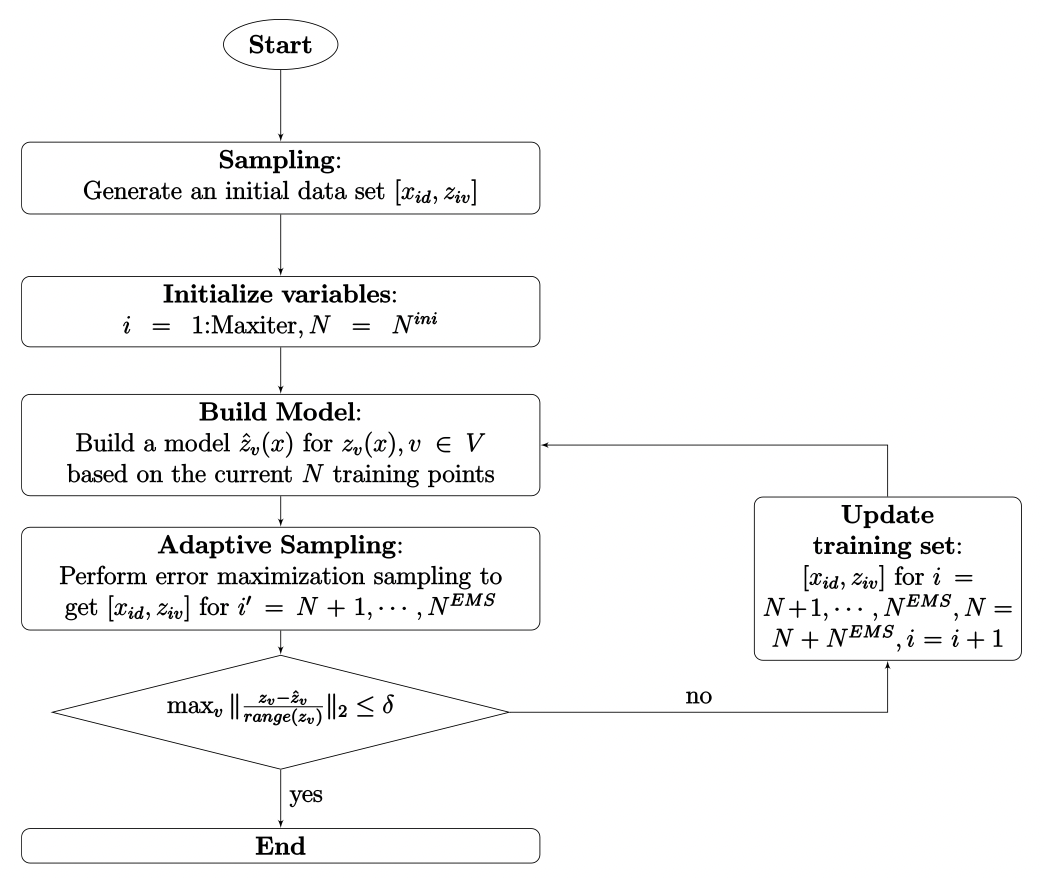


### Example

Now, we will demonstrate how to use an existing implementation of ALAMO with a Python interface, which was created by the authors of the method. The first step will be to get an academic license with your college email from the official ALAMO site: https://minlp.com/alamo-licenses

The license will be emailed to you as a text file within a few days of the request. You need to open it with a text editor (Notaped, VSCode, etc...) and copy the contents to the cell bellow.

In [ ]:
from pathlib import Path

working_dir = Path.cwd()
print(working_dir)

In [ ]:
license = """
COPY YOUR LICENSE HERE (SUBSTITUTE ALL THIS STRING)
MAKE SURE TO EXECUTE THIS CELL AFTERWARDS
"""

license_file = working_dir / "alamo-linux64" / "alamolice.txt"
with open(license_file, "w") as file:
  file.write(license.lstrip("\n").rstrip("\n"))

Simple example to see if we can generate this model $$z = x^2 + y^2$$

In [39]:
import numpy as np
from alamopy.almain import doalamo

def random_data_alamo(fun, npoints, ninputs, input_ranges=None):
    "This function generates random datapoints over the specified input ranges"

    xdata = np.random.rand(npoints, ninputs)
    
    if input_ranges:
        assert len(input_ranges) == ninputs, "Specify the sampling range for each input variable."
        assert all(lambda x: len(x) == 2, input_ranges), "Ranges should be an array of tuples."
        assert all(lambda x: x[1] - x[0] > 0, input_ranges), "Ranges should have the form (lower_bound, upper_bound)."
    else:
        input_ranges = [(0,1)  for _ in range(ninputs)]
        
    for (lower, upper) in input_ranges:
        width = upper - lower
        
        # make x_i in [lower, upper]
        xdata[:, 0] *= width
        xdata[:, 0] += lower

    zdata = fun(*[xdata[:,i] for i in range(xdata.shape[1])])
    return xdata, zdata

In [ ]:
# xdata = np.random.rand(10, 3)
# xdata[:, 0] *= 10  # Make x1 go from 0 to 10
# xdata[:, 1] *= 5  # Make x2 go from 0 to 5

# zdata = xdata[:, 0] ** 2 + xdata[:, 1] ** 2

def alamo_example(x, y, *args):
    return x ** 2 + y ** 2

npoints = 10
nvars = 2
xdata, zdata = random_data_alamo(alamo_example, npoints, nvars)

In [40]:
opts = doalamo(
    xdata,
    zdata,
    noutput=1,
    keep_alm_file=True,
    keep_lst_file=True,
    print_alm_output=True,
    monomialpower=[2, 3],
    crncustom=1,
    zlabels=["z"],
    customcon=["1 -z"],
)

 ***************************************************************************
 ALAMO version 2022.10.7. Built: LNX-64 Fri Oct 7 21:05:57 EDT 2022 

 If you use this software, please cite:
 Cozad, A., N. V. Sahinidis and D. C. Miller,
 Automatic Learning of Algebraic Models for Optimization,
 AIChE Journal, 60, 2211-2227, 2014.

 ALAMO is powered by the BARON software from http://www.minlp.com/
 ***************************************************************************
 Licensee: Ilya Sandoval at Imperial College London, os220@ic.ac.uk.
 ***************************************************************************
 Reading input data
 Checking input consistency and initializing data structures
 
 Step 0: Initializing data set
 User provided an initial data set of 10 data points
 We will sample no more data points at this stage
 ***************************************************************************
 Iteration 1 (Approx. elapsed time 0.44E-02 s)
 
 Step 1: Model building using BIC
 
 M

In [ ]:
opts["out"]["z"]

## Symbolic Regression - Genetic Programming

### Explanation

Symbolic regression is the most generalisable method, as a design matrix does not need to be constructed (i.e.: the matrix of non-linear transformations of state variables that a modeller believes could be present in a given surrogate model). Instead, in this framework, building blocks are specified which define a feasible mathematical expression space. These building blocks can be state variables (e.g.: $C_A$, $C_B$, $T$), mathematical operators (e.g.: '+', '-', 'cos', 'sin'), or user-defined analytical functions (e.g.: $\frac{1}{k_1C_A+k_2C_B}$). 

Many algorithms have been used to implement symbolic regression, such as genetic programming, compressed-sensing, Bayesian optimisation or deep learning. Here, the focus will be on symbolic regression implemented with genetic programming (SR-GP), as this is the most widely used approach for symbolic regression. 

An important distinction should be made between genetic programming and genetic algorithm: GP is a special case od GA where the candidate solutions of an optimisation problem are programs (i.e.: functions/equations) instead of coordinate values. As such, the concept of GP is analgous to GA, where solutions are evolved based on Darwin's theory of evolution: survival of the fittest. 

For the SR framework, this concept is translated as follows: an initial population of $\textit{m}$ models is generated and their fitness is computed (here, the fitness refers to the error between the prediction from the model generated and our data); $\textit{n}$ number of models are selected and $\textit{m}-\textit{n}$ models are killed (i.e.: these models will no longer be considered); the $\textit{n}$ selected models are allowed to crossover and produce $\textit{m}-\textit{n}$ offspring (this is important to maintain the size of the population constant throughout generations, so our population does not explode or vanish); with a given probability $\textit{p}$ the $\textit{m}-\textit{n}$ offspring models are mutated (here, mutated refers to a given mathematical building block of the model to be changed randomly with some
probability $\textit{p}$); the fitness of the offspring models are computed and the process is iterated until convergence or a termination criterion is achieved. A pseudocode of GP is provided below for clarity, along with a figure to graphically illustrate the concepts of crossover and mutation in the SR framework.

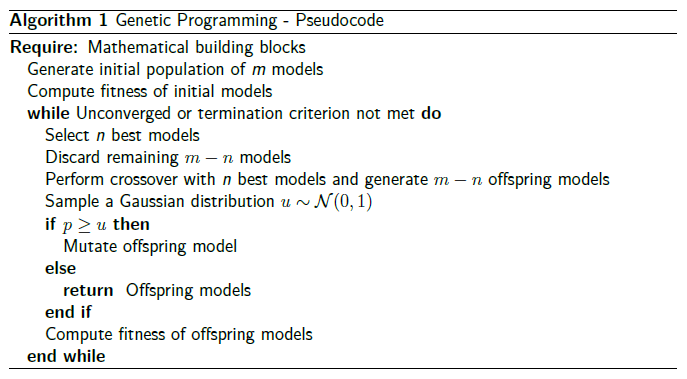

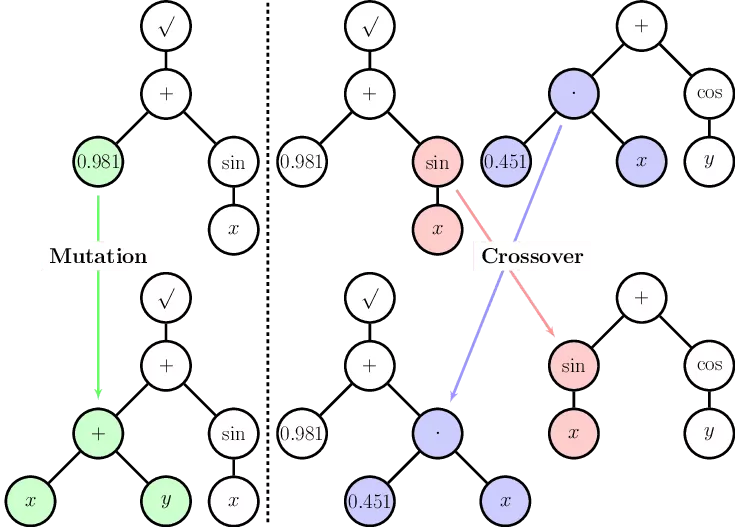

### Example

Now, we will demonstrate how to use an existing implementation of SR-GP by Miles Cranmer (for those interested, the GitHub repository can be found [here](https://https://github.com/MilesCranmer/PySR)). The first step will be to install and import all necessary packages, as well as generating some data for us to benchmark the framework. For this particular example, a simple one-dimensional function will be used:

$$f(x)=sin(x) + sin(\frac{10x}{3})$$

In [ ]:
#Importing all necessary python packages#
import numpy as np
import matplotlib.pyplot as plt
from pysr import PySRRegressor
np.random.seed(1998)

In [ ]:
#Generating data#
def func_1(x):
  return np.sin(x)+np.sin(10*x/3)

lower_bound = -6
upper_bound = 6
number_datapoints = 2000
x = np.linspace(lower_bound,upper_bound,number_datapoints)
y = func_1(x)
observed_y = y # + np.random.normal(0,0.1,number_datapoints)  # uncomment this to try adding noise to the data

In [ ]:
#Plotting data#
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x, y, label='True Function', color='r', linewidth=3, alpha=0.6)
ax.scatter(x, observed_y, color='b', s=3, label='Observed Datapoints')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(alpha=0.5)
ax.legend(loc=1)
plt.show()

Once we have generated and plotted our data, the next step, as per the explanation provided, is to choose which building blocks we will be using to construct our surrogate model.

As we can see from the generated plot, our underlying function has some sinusoidal behaviour, and therefore, we should probably include 'sin' as a building block. We will not be including any other trignometric functions because: they can be expressed as a function of 'sin' (remember trignometric identities?) and it is better to start with a limited number of building blocks (to limit the search space - computational reason) and increase it if need be. We will also compliment 'sin' with very common operators such as '+', '-', '*', '/'. 

In [ ]:
#Running PySR - this might take some time, be patient#
x = x.reshape(-1, 1)
observed_y = observed_y.reshape(-1, 1)
file_name = str('hall_of_fame_'+'func_1'+'.csv')
model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "*", "/", "-"],
    unary_operators=["sin"],
    model_selection="accuracy",
    loss="loss(x, y) = (x - y)^2",  # Custom loss function (julia syntax)
    maxsize = 20,
    timeout_in_seconds = 300,
    parsimony = 1e-5,
    equation_file= file_name,
)

model.fit(x,observed_y)

# EXERCISES

It is now your turn to use the introduced methods and see how they perform when you need to retrieve a model. You should try to use the methods as if you did not know the data-generating model (which in real life, you would not). Maybe you could start by plotting the data and judging what kind of variables and operators should be present in the surrogate. But feel free to try any other strategy. 

You will be working with: the Beale function, the Booth function and the Matyas function. Find them all below. To help you get started, we have generated the necessary data below.

#### Matyas function

$$f(x,y)=0.26\left(x^{2}+y^{2}\right)-0.48xy$$

#### Booth function

$$f(x,y)=\left(x+2y-7\right)^{2}+\left(2x+y-5\right)^{2}$$

#### Beale function

$$f(x,y)=\left(1.5-x+xy\right)^{2}+\left(2.25-x+xy^{2}\right)^{2}  + \left(2.625-x+xy^{3}\right)^{2}$$

In [41]:
# You can use the random_data_alamo function above to generate the datasets for this functions, or write your own data generation logic.

def Matyas(x, y, *args):
    return 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

def Booth(x, y, *args):
    return (x + 2*y - 7) ** 2 + (2*x + y - 5) ** 2

def Beale(x, y, *args):
    return (1.5-x+x*y)**2 + (2.25-x+x*y**2)**2 + (2.625-x+x*y**3)**2